## Jupyter Notebook Version for FunSearch Pipeline

In [ ]:
# ──────────────────────────────────── Imports ────────────────────────────────────
import os
import sqlite3
import subprocess
import re
import random
from pathlib import Path
from openai import OpenAI
from dotenv import load_dotenv
from PromptGenerator import PolicyPromptGenerator
from RAG import ExperimentRAG

In [ ]:
# ──────────────────────────────────── Configuration ────────────────────────────────────
DB_NAME = "funsearch.db"
WORKLOAD = "Astar"
WORKLOAD_DESCRIPTION = "astar is derived from a portable 2D path-finding library that is used in game's AI. This library implements three different path-finding algorithms: First is the well known A* algorithm for maps with passable and non-passable terrain types. Second is a modification of the A* path finding algorithm for maps with different terrain types and different move speed. Third is an implementation of A* algorithm for graphs. This is formed by map regions with neighborhood relationship. The library also includes pseudo-intellectual functions for map region determination."
TRACE_PATH = Path("ChampSim_CRC2/trace/astar_313B.trace.gz")
LIB_PATH = "ChampSim_CRC2/lib/config1.a"
INCLUDE_DIR = "ChampSim_CRC2/inc"
EXAMPLE_DIR = Path("ChampSim_CRC2/example")
POLICY_TEXT_PATH = "generated_policies"
WARMUP_INST = "1000000"
SIM_INST = "10000000"
MODEL = "o4-mini"
ITERATIONS = 3
ALL_METRICS = []
MUTATIONS = [
    "Completely abandon LRU and use purely Random eviction.",
    "Switch to LFU (Least Frequently Used) based on access counts.",
    "Implement a weighted random eviction based on last access time.",
    "Keep prefetched blocks longer than normal ones.",
    "Age every cache line aggressively and evict the oldest.",
    "Prefer to evict dirty cache lines first.",
    "Invent a fresh eviction heuristic combining random + frequency.",
    "Mimic Belady's future knowledge using random farthest accesses.",
    "Use program counter (PC)-based prediction for eviction scoring.",
    "Mix recency and frequency into a custom scoring function.",
    "Implement MRU (Most Recently Used) instead of LRU to test corner behavior.",
    "Randomly shuffle eviction candidates and pick based on modular hashing."
]
REFINEMENTS = [
    "Refine the eviction policy by minimizing metadata overhead.",
    "Tune timestamp granularity to reduce contention.",
    "Optimize metadata initialization to avoid unnecessary resets.",
    "Prefer static inline functions for victim selection logic.",
    "Introduce priority between load hits and RFO hits.",
    "Slightly prioritize lines with low reuse distance.",
    "Add minimal adaptive randomization to avoid pathological worst cases.",
    "Balance dirty vs clean lines more delicately during eviction."
]

EXAMPLE_DIR.mkdir(parents=True, exist_ok=True)

load_dotenv(dotenv_path=Path(".env"), override=False)
client = OpenAI(
        api_key=os.getenv("OPENAI_API_KEY"),
)

In [ ]:
# ──────────────────────────────────── Load RAG ────────────────────────────────────
rag = ExperimentRAG(DB_NAME)  

try:
    response = rag.generate_response(WORKLOAD)
    print(response)
    
    # Example 2: Get raw policy data for further processing
    top_policies = rag.get_top_policies_by_cache_hit(WORKLOAD)
    print("\nRaw policy data:")
    for policy in top_policies:
        print(f"Policy: {policy['policy']}")
        print(f"Policy Description: {policy['policy_description']}")
        print(f"Workload Description: {policy['workload_description']}")
        print(f"Cache hit rate: {policy['cache_hit_rate']:.2%}")
        print(f"CPP file: {policy['cpp_file_path']}\n")
        
finally:
    # Ensure the connection is closed
    rag.close()

Workload: Astar
Description: astar is derived from a portable 2D path-finding library that is used in game's AI. This library implements three different path-finding algorithms: First is the well known A* algorithm for maps with passable and non-passable terrain types. Second is a modification of the A* path finding algorithm for maps with different terrain types and different move speed. Third is an implementation of A* algorithm for graphs. This is formed by map regions with neighborhood relationship. The library also includes pseudo-intellectual functions for map region determination.

Top 2 policies by cache hit rate:

1. Policy: SHiP-Enhanced RRIP (SER-RRIP)
   Description: SER-RRIP combines a 2-bit Signature History Counter Table (SHCT) from SHiP with SRRIP’s re-reference prediction to guide insertions. Each load‐PC is hashed into the SHCT, which tracks whether past blocks from that PC were re-referenced. On a miss, if the SHCT counter for the PC indicates “likely reused,” the ne

In [ ]:
import re
from pathlib import Path
from typing import Optional, Tuple

# ───────────────────────── Prompt Generator ──────────────────────────
def generate_prompt():
    generator = PolicyPromptGenerator(DB_NAME)
    prompt=""
    try:
        # Generate the prompt
        prompt = generator.generate_prompt(WORKLOAD)
        # Print or send to LLM
        
    finally:
        generator.close()

    # print(prompt)
    return prompt

# ───────────────────────── Helpers ──────────────────────────
def _extract(pattern: str, text: str) -> Optional[str]:
    """Return first capture group or None if not found."""
    m = re.search(pattern, text, flags=re.DOTALL | re.IGNORECASE)
    return m.group(1).strip() if m else None

# ───────────────────────── Policy Parser ───────────────────────────
def parse_policy_content(file_path: str) -> Tuple[Optional[str], ...]:
    content = Path(file_path).read_text(encoding="utf-8")

    newline = r'(?:\r\n|\n|\r)'        # tolerate any line ending
    name_pat = rf'##\s*Policy\s*Name\s*{newline}(.*?){newline}'
    desc_pat = rf'##\s*Policy\s*Description\s*{newline}(.*?){newline}##'
    code_pat = r'```cpp\s*(.*?)\s*```'            # code fence
    class_pat = r'class\s+(\w+)\s*(?:[:{])'       # optional `:`

    policy_name = _extract(name_pat,  content)
    policy_desc = _extract(desc_pat,  content)
    cpp_code    = _extract(code_pat,   content)
    class_name  = _extract(class_pat,  cpp_code or "")  # search only in code

    return policy_name, policy_desc, cpp_code, class_name

# ───────────────────────── File Name Extraction ───────────────────────────
def extract_abbreviation(policy_name: str) -> str:
    """
    If the policy name contains a parenthesized abbreviation,
    return the contents of the parentheses.
    Otherwise, build an abbreviation from the initial letters
    of each word and each hyphen-separated sub-word.
    """
    # 1) Look for text inside the first pair of parentheses
    m = re.search(r'\(([^)]+)\)', policy_name)
    if m:
        inside = m.group(1).strip()
        # if parentheses hold more than one word, treat it as expansion
        if ' ' in inside:
            # return the token before the parentheses
            return policy_name.split()[0].lower()
        return inside.lower()

    # 2) No parentheses -> build initials
    abbrev_chars = []
    # split on whitespace
    for token in policy_name.split():
        # further split on hyphens
        for sub in token.split('-'):
            if sub:  # non-empty
                abbrev_chars.append(sub[0].upper())

    return ''.join(abbrev_chars)

# ───────────────────────── Policy Compilation ───────────────────────────
def compile_policy(policy_file_name: str, cpp_code: str) -> str:
    policy_file_path = Path(f"{EXAMPLE_DIR}/{policy_file_name}.cc")
    policy_file_path.write_text(cpp_code, encoding="utf-8")

    print(f"───────────────────────── Compiling {policy_file_name}.cc... ─────────────────────────")
    result = subprocess.run(
        f"g++ -Wall -std=c++17 -o {EXAMPLE_DIR}/{policy_file_name}.out {EXAMPLE_DIR}/{policy_file_name}.cc {LIB_PATH}",
        shell=True, capture_output=True, text=True
    )

    return result

# ───────────────────────── Champsim Simulator ───────────────────────────
def simulate_policy(policy_file_name: str) -> str:
    print(f"───────────────────────── Simulating {policy_file_name}.out... ─────────────────────────")
    run_cmd = [
        str(EXAMPLE_DIR/f"{policy_file_name}.out"),
        "-warmup_instructions", WARMUP_INST,
        "-simulation_instructions", SIM_INST,
        "-traces", str(TRACE_PATH)
    ]
    result = subprocess.run(run_cmd, check=True, capture_output=True, text=True)
    output = result.stdout
    print(output)
    return output

# ───────────────────────── Extract Key Evaluation Metrics ───────────────────────────
from typing import Dict

def extract_metrics(output: str) -> Dict[str, float]:
    """Extract all relevant metrics from ChampSim output."""
    metrics = {}

    # LLC TOTAL Accesses, Hits, Misses
    m_llc = re.search(r"LLC TOTAL\s+ACCESS:\s+(\d+)\s+HIT:\s+(\d+)\s+MISS:\s+(\d+)", output)
    if m_llc:
        metrics["llc_accesses"] = int(m_llc.group(1))
        metrics["llc_hits"] = int(m_llc.group(2))
        metrics["llc_misses"] = int(m_llc.group(3))
    else:
        raise RuntimeError("Failed to find LLC TOTAL statistics in output.")

    # Instructions
    m_inst = re.search(r"instructions:\s+(\d+)", output)
    if m_inst:
        metrics["instructions"] = int(m_inst.group(1))

    # Cycles
    m_cycles = re.search(r"cycles:\s+(\d+)", output)
    if m_cycles:
        metrics["cycles"] = int(m_cycles.group(1))

    # IPC
    m_ipc = re.search(r"cumulative IPC:\s+([0-9.]+)", output)
    if m_ipc:
        metrics["ipc"] = float(m_ipc.group(1))

    # Measured LLC Hit Rate
    m_measured_hit_rate = re.search(r"Measured LLC hit rate:\s+([0-9.]+)", output)
    if m_measured_hit_rate:
        metrics["measured_hit_rate"] = float(m_measured_hit_rate.group(1))
    else:
        # Calculate hit rate manually if needed
        metrics["measured_hit_rate"] = round(metrics["llc_hits"] / metrics["llc_accesses"], 4)

    return metrics


# ───────────────────────── DB Commit ───────────────────────────
def update_policy_database(policy_name: str, policy_desc: str, policy_file_path: str, hit_rate: float) -> None:
    db = sqlite3.connect("funsearch.db")
    c  = db.cursor()

    # Fill in these from your context:
    policy_name          = policy_name         # from your parser
    policy_description   = policy_desc  # from your parser
    cpp_file_path        = str(policy_file_path)               # always this path
    score                = hit_rate                   # or your custom scoring

    c.execute(
        """
        INSERT INTO experiments
        ( workload,
            policy,
            policy_description,
            workload_description,
            cpp_file_path,
            cache_hit_rate,
            score
        )
        VALUES (?, ?, ?, ?, ?, ?, ?)
        """,
        (
            WORKLOAD,
            policy_name,
            policy_description,
            WORKLOAD_DESCRIPTION,
            cpp_file_path,
            hit_rate,
            score
        )
    )

    db.commit()
    db.close()

    print("✅ New experiment recorded in funsearch.db")

In [ ]:
# ───────────────────────── Plotting Visualization ───────────────────────────
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(metrics_list):
    """Plot all major extracted metrics for multiple policies."""

    iterations = list(range(1, len(metrics_list)+1))

    # Extract individual lists
    mpki = [(m['llc_misses'] / m['instructions']) * 1000 if m.get('instructions') else float('inf') for m in metrics_list]
    ipc = [m.get('ipc', 0) for m in metrics_list]
    hit_rate = [m.get('measured_hit_rate', 0) for m in metrics_list]
    miss_rate = [1 - hr for hr in hit_rate]

    best_so_far_mpki = np.minimum.accumulate(mpki)
    smoothed_mpki = np.convolve(mpki, np.ones(5)/5, mode='valid')

    # --- MPKI vs Iteration ---
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, mpki, marker='o', label='MPKI')
    plt.plot(iterations, best_so_far_mpki, linestyle='--', label='Best-so-Far MPKI')
    plt.title('MPKI and Best-So-Far MPKI')
    plt.xlabel('Iteration')
    plt.ylabel('MPKI')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig("mpki_iter.png", dpi=300)

    # --- Smoothed MPKI ---
    plt.figure(figsize=(10, 6))
    plt.plot(range(5, len(smoothed_mpki)+5), smoothed_mpki, marker='x', color='purple')
    plt.title('Smoothed MPKI (5-Iteration Moving Average)')
    plt.xlabel('Iteration')
    plt.ylabel('MPKI (Moving Average)')
    plt.grid(True)
    plt.show()
    plt.savefig("mpki_iter_smoothed.png", dpi=300)

    # --- IPC vs Iteration ---
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, ipc, marker='x', color='orange')
    plt.title('IPC vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Instructions Per Cycle (IPC)')
    plt.grid(True)
    plt.show()
    plt.savefig("ipc_iter.png", dpi=300)

    # --- LLC Hit Rate vs Iteration ---
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, hit_rate, marker='s', color='green')
    plt.title('LLC Hit Rate vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Hit Rate')
    plt.grid(True)
    plt.show()
    plt.savefig("hitrate_iter.png", dpi=300)

    # --- LLC Miss Rate vs Iteration ---
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, miss_rate, marker='d', color='red')
    plt.title('LLC Miss Rate vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Miss Rate')
    plt.grid(True)
    plt.show()
    plt.savefig("missrate_iter.png", dpi=300)

    # --- IPC vs MPKI Scatter ---
    plt.figure(figsize=(10, 6))
    plt.scatter(mpki, ipc, alpha=0.8)
    plt.title('IPC vs MPKI (Performance Tradeoff)')
    plt.xlabel('MPKI (Lower is Better)')
    plt.ylabel('IPC (Higher is Better)')
    plt.grid(True)
    plt.show()
    plt.savefig("ipc_mpki.png", dpi=300)


In [ ]:
def plot_policy_vs_score(policies, cache_hit_rates):
    """
    Plot policy names vs a specific score (e.g., hit rate, MPKI).
    """
    # Unpack
    # policies = [row[0] for row in results]
    # hit_rates = [row[1] for row in results]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.barh(policies, cache_hit_rates, color='teal')
    plt.title(f'Policy vs Cache Hit Rate (Workload: {WORKLOAD})')
    plt.xlabel('Cache Hit Rate')
    plt.ylabel('Policy Name')
    plt.gca().invert_yaxis()

     # Finer x-axis ticks
    min_tick = 0.0
    max_tick = max(cache_hit_rates) + 0.05   # some margin
    plt.xticks(np.arange(min_tick, max_tick, 0.05))  # every 0.025 step

    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    plt.savefig("policy_score.png", dpi=300)

[('SHiP-Enhanced RRIP (SER-RRIP)', 0.5049052786006889), ('DIP-RRIP (Dueling Insertion Policy RRIP)', 0.504888446328084), ('SHiP: Signature-based Hit Predictor', 0.47016346794426567), ('Enhanced TTL-SHiP RRIP (ETSRRIP)', 0.46873626840919075), ('SHiP-RRIP (Signature-based Hit Predictor with RRIP)', 0.4625969184538406), ('LRU', 0.4545), ('Adaptive SHiP-RRIP Replacement (ASHR)', 0.4516417667153326), ('Dynamic RRIP (DRRIP)', 0.4479758749238118), ('Dynamic Insertion RRIP (DIP‐RRIP)', 0.44447121858566385), ('Dynamic Insertion SRRIP with Set‐Dueling (DIP‐SRRIP)', 0.44332219450311133), ('SHiP‐SRRIP', 0.4326478759443791), ('Dynamic Re‐Reference Interval Prediction (DRRIP)', 0.4291928305149612), ('Reordering-based Cache Replacement', 0.411), ('Multiperspective', 0.371), ('Hawkeye', 0.3574), ('Less is More', 0.3382), ('Ship++', 0.3382), ('Adaptive Signature-Dueling RRIP (ASD-RRIP)', 0.2967827268684299), ('SVB-RRIP (Signature‐Based Victim Bypass RRIP)', 0.2877282101801585)]


In [ ]:
prompt_gen = PolicyPromptGenerator()

def policy_generation_loop():

    best_hit = top_policies[0]['cache_hit_rate']
    current_hit = best_hit
    reward = "Penalty"

    for i in range(ITERATIONS):
        # 1. Start a new iteration
        print(f"───────────────────────── Iteration {i + 1}/{ITERATIONS} ─────────────────────────")

        # 2. Initialize variables
        prev_name = prev_desc = prev_code = None
        current_hit = best_hit

        for j in range(ITERATIONS):
            # 2.1 Reinforce the prompt with a mutation or refinement
            
            # 3. Generate a new prompt
            if i == 0:
                prompt = generate_prompt()
            else:
                # Reward vs. Penalty message
                if current_hit > best_hit:
                    feedback = (
                        f"Great! Policy improved from {best_hit} to "
                        f"{current_hit}. Please refine further."
                    )
                    best_hit = current_hit
                else:
                    feedback = (
                        f"Policy hit rate was {current_hit}, not better than "
                        f"{best_hit}. Try a different approach."
                    )
                prompt = (
                    f"You previously designed **{prev_name}**:\n\n"
                    f"Description:\n{prev_desc}\n\n"
                    f"Implementation:\n```cpp\n{prev_code}\n```\n\n"
                    f"{feedback}\n\n"
                    "Now improve or redesign this cache replacement policy for the same workload.\n"
                    "Use the exact output format:\n\n"
                    "## Policy Name\n<name>\n\n"
                    "## Policy Description\n<one paragraph>\n\n"
                    "## C++ Implementation\n"
                    f"{prompt_gen._get_code_template()}\n"
                )

            # 4. Send the prompt to the LLM
            policy = client.chat.completions.create(
                model="o4-mini",
                store=True,
                messages=[{"role": "user", "content": prompt}],
            )
            print("───────────────────────── Generating policy... ─────────────────────────")
            policy = policy.choices[0].message.content

            # 5. Save the generated policy to a file
            output_file = Path(f"{POLICY_TEXT_PATH}/generated_policy_{i}_{j}.txt")
            os.makedirs(output_file.parent, exist_ok=True)
            output_file.write_text(policy, encoding="utf-8")

            policy_name, policy_desc, cpp_code, class_name = parse_policy_content(f"{POLICY_TEXT_PATH}/generated_policy_{i}_{j}.txt")
            policy_file_name = extract_abbreviation(policy_name).lower()
            print("Name :", policy_name)
            print("Abbrev:", policy_file_name)
            print("Desc :", policy_desc[:80], "…")
            print("Code :", cpp_code)
            print("Class:", class_name)

            # 6. Compile the policy
            compiled_policy = compile_policy(policy_file_name, cpp_code)
            if compiled_policy.stderr.strip():
                print(compiled_policy.stderr)

            # 7. Simulate the policy on Champsim
            simulation_output = simulate_policy(policy_file_name)
            
            metrics = extract_metrics(simulation_output)
            ALL_METRICS.append(metrics)

            # 9. Update the database with the new policy
            update_policy_database(
                policy_name,
                policy_desc,
                f"{EXAMPLE_DIR}/{policy_file_name}.cc",
                metrics["measured_hit_rate"]
            )

        # 10. Prepare for the next iteration
        prev_name, prev_desc, prev_code = policy_name, policy_desc, cpp_code
    
    plot_metrics(ALL_METRICS)
    prompt_gen.close()

───────────────────────── Iteration 1/3 ─────────────────────────
───────────────────────── Generated Prompt: ─────────────────────────
───────────────────────── Generating policy... ─────────────────────────
Name : Dynamic Signature-based RRIP (DSR)
Abbrev: dsr
Desc : DSR is a hybrid replacement policy combining Signature-based Hit Predictor (SHiP …
Code : #include <vector>
#include <cstdint>
#include <iostream>
#include "../inc/champsim_crc2.h"

#define NUM_CORE 1
#define LLC_SETS (NUM_CORE * 2048)
#define LLC_WAYS 16

// SRRIP parameters
static const uint8_t maxRRPV = 3;

// Signature predictor parameters
static const int PC_BITS = 10;
static const int PCs = (1 << PC_BITS);
static const uint8_t InsertionThreshold = 128; // >= hot insertion
static const uint8_t BypassThreshold   =  64; // < bypass on loads

// Replacement state
static uint8_t rrpv   [LLC_SETS][LLC_WAYS];
static uint8_t sigCtr [NUM_CORE][PCs];                     // per-PC saturating counter
static uint16_t fillSig[LL

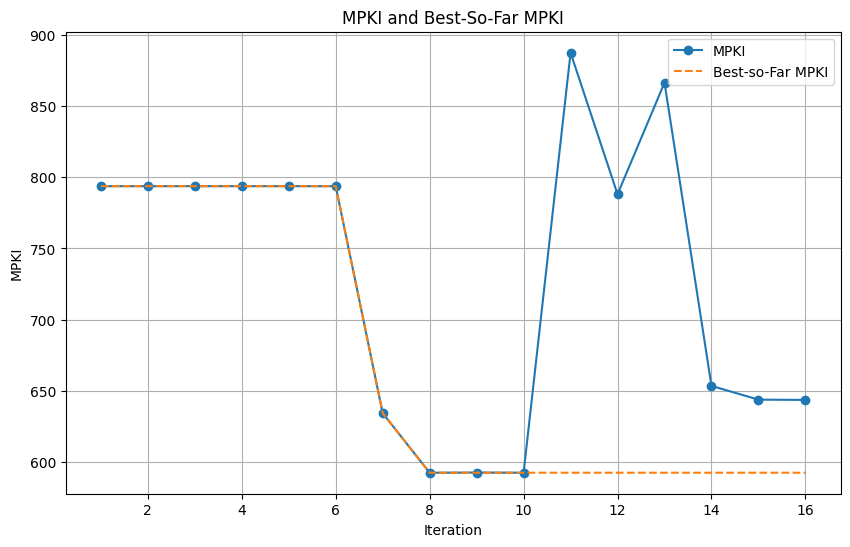

<Figure size 640x480 with 0 Axes>

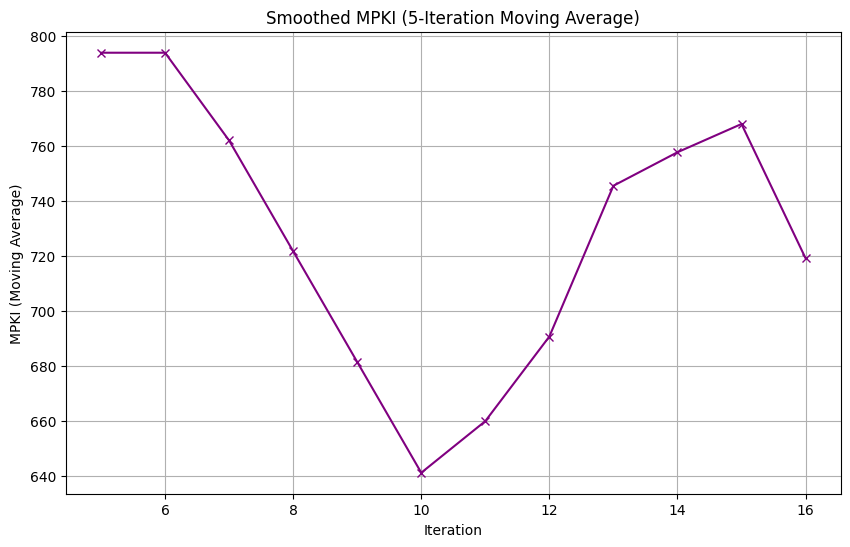

<Figure size 640x480 with 0 Axes>

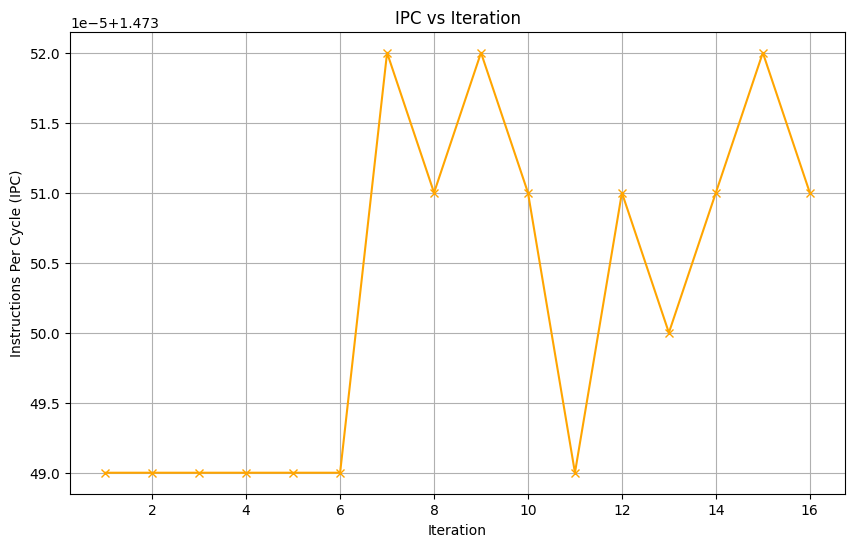

<Figure size 640x480 with 0 Axes>

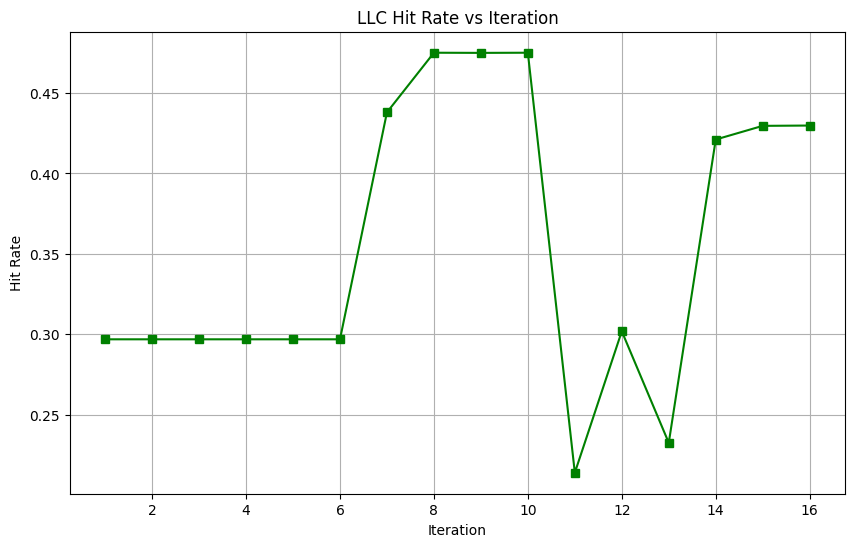

<Figure size 640x480 with 0 Axes>

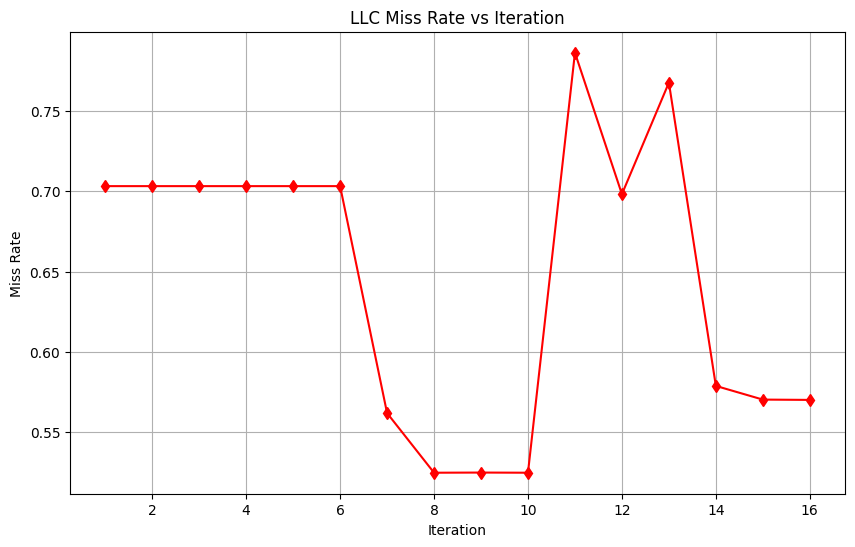

<Figure size 640x480 with 0 Axes>

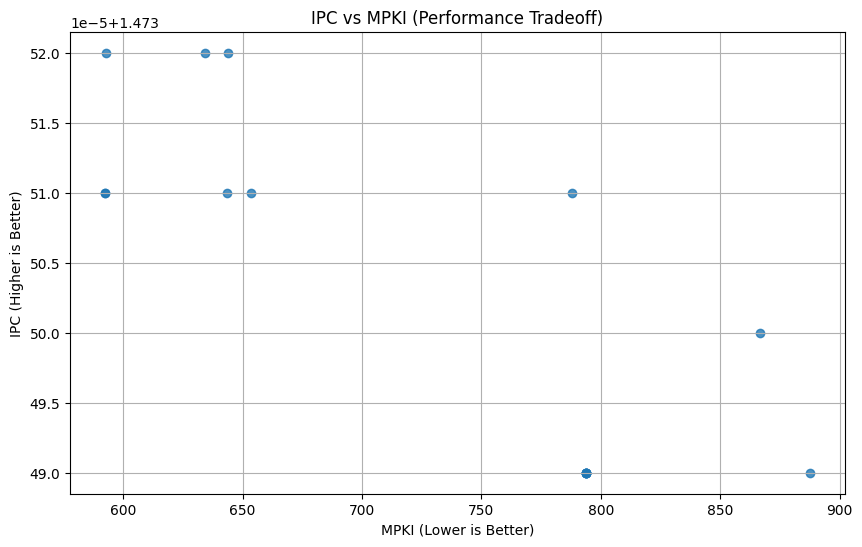

<Figure size 640x480 with 0 Axes>

In [14]:
policy_generation_loop()

[('SHiP-Enhanced RRIP (SER-RRIP)', 'ChampSim_CRC2/example/ship_enhanced_rrip__ser_rrip.cc', 0.5049052786006889), ('DIP-RRIP (Dueling Insertion Policy RRIP)', 'ChampSim_CRC2/example/dip_rrip__dueling_insertion_policy_rrip.cc', 0.504888446328084), ('SHiP: Signature-based Hit Predictor', 'ChampSim_CRC2/example/ship__signature_based_hit_predictor.cc', 0.47016346794426567), ('Enhanced TTL-SHiP RRIP (ETSRRIP)', 'ChampSim_CRC2/example/enhanced_ttl_ship_rrip__etsrrip.cc', 0.46873626840919075), ('SHiP-RRIP (Signature-based Hit Predictor with RRIP)', 'ChampSim_CRC2/example/ship_rrip__signature_based_hit_predictor_with_rrip.cc', 0.4625969184538406), ('LRU', './ChampSim_CRC2/example/lru.cc', 0.4545), ('Adaptive SHiP-RRIP Replacement (ASHR)', 'ChampSim_CRC2/example/adaptive_ship_rrip_replacement__ashr.cc', 0.4516417667153326), ('Dynamic RRIP (DRRIP)', 'ChampSim_CRC2/example/dynamic_rrip__drrip.cc', 0.4479758749238118), ('Dynamic Insertion RRIP (DIP‐RRIP)', 'ChampSim_CRC2/example/dynamic_insertion_r

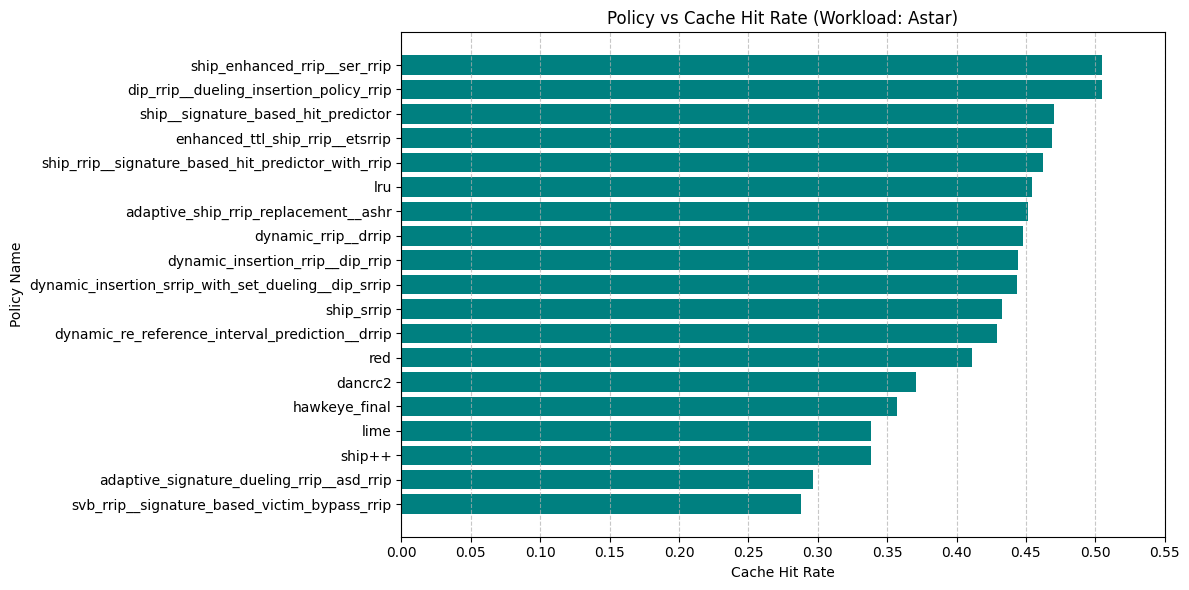

<Figure size 640x480 with 0 Axes>

In [ ]:
# ───────────────────────── Plotting Visualization ───────────────────────────
conn = sqlite3.connect(DB_NAME)
c = conn.cursor()

# Query
c.execute("""
    SELECT policy, cpp_file_path, cache_hit_rate
    FROM experiments
    WHERE workload = ?
    ORDER BY cache_hit_rate DESC
""", (WORKLOAD,))

results = c.fetchall()
conn.close()
print(results)
if not results:
    print("No policies found for workload:", WORKLOAD)
    exit(1)

print(results)
policies = [row[0] for row in results]
policy_file_names = [row[1].split('/')[-1][:-3] for row in results]
hit_rates = [round(row[2], 4) for row in results]

plot_policy_vs_score(policy_file_names, hit_rates)